In [8]:
using JuMP
using Gurobi
using StaticArrays
using Rotations
using GeometryTypes
using DrakeVisualizer
using FileIO
using CoordinateTransformations
using Plots
using PyPlot
vis = Visualizer()

Visualizer with path prefix Symbol[] using LCM LCMCore.LCM(Ptr{Void} @0x0000000006c96ed0,"",RawFD(58),LCMCore.Subscription[LCMCore.Subscription{LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#8{DrakeVisualizer.CoreVisualizer}}}(LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#8{DrakeVisualizer.CoreVisualizer}}(DrakeVisualizer.Comms.CommsT,DrakeVisualizer.handle_msg),Ptr{Void} @0x0000000006c88dd0)])

In [149]:
box = load("cube.obj")

points = decompose(Point{3,Float64}, box)
faces = decompose(Face{3, Int, 0}, box)
# Build vertex-membership matrix F, 
# where F[i, j] == 1 --> 
#         vertex j is a member of face i
F = Array{Float64}(size(faces, 1), size(points, 1))
F .= 0.0
for i = 1:size(faces, 1)
    for j = faces[i]
        F[i, j] = 1
    end
end
# Convert points into modelVerts
modelVerts = Array{Float64}(3, size(points, 1))
for i=1:size(points, 1)
    for k=1:3
        modelVerts[k, i] = points[i][k]
    end
end

function getFaceArea(points, face::Face)
    a = points[face[1]]
    b = points[face[2]]
    c = points[face[3]]
    return norm(cross(b - a, c - a)) / 2.
end

function samplePointsFromMesh(N_points, points, faces)
    # Get normalized cumulative area of faces
    cum_area = Array{Float64}(size(faces, 1))
    for i = 1:size(faces, 1)
        cum_area[i] = getFaceArea(points, faces[i])
    end
    cum_area = cumsum(cum_area)
    cum_area /= cum_area[end]
    
    sampled_pts = Array{Float64}(3, N_points)
    sampled_faces = zeros(N_points, size(faces, 1))
    for i=1:N_points
        # Pick the face we'll sample from
        sample = rand()
        k = findfirst(cum_area .>= sample)
        a = points[faces[k][1]]
        b = points[faces[k][2]]
        c = points[faces[k][3]]
        
        sampled_faces[i, k] = 1
            
        s1 = rand()
        s2 = rand()
        while (s1 + s2 > 1.0)
            s1 = rand()
            s2 = rand()
        end
        pt = a + s1*(b - a) + s2*(c - a)
        for k=1:3
            sampled_pts[k, i] = pt[k]
        end
    end
    return (sampled_pts, sampled_faces)
end
ret = samplePointsFromMesh(100, points, faces);
modelPoints = ret[1]
modelPointsFacesGT = ret[2];

In [150]:
T0 = [0.1; 0; 0.5]
R0 = [0.860089 0.174349 -0.479426; 0.244566 0.683829 0.687434; 0.447698 -0.708506 0.545514]

function convertToPointCloudType(points)
    return PointCloud([[points[1, i], points[2, i], points[3, i]] for i=1:size(points, 2)]) 
end

scenePoints = transpose(R0)*modelPoints + repmat(-transpose(R0)*T0, 1, size(modelPoints, 2))

N_outliers = 100
scenePointsOutliers = (rand(3, N_outliers)-0.5)*10.
scenePoints = cat(2, scenePoints, scenePointsOutliers)
scenePointsFacesGT = cat(1, modelPointsFacesGT, zeros(N_outliers, size(modelPointsFacesGT, 2)))
#scenePoints += (rand(3, size(scenePoints, 2))-0.5)*2*0.05


pointcloud = convertToPointCloudType(scenePoints)
box_vis = setgeometry!(vis[:julia][:box_vis], box)
setgeometry!(vis[:julia][:scene_pts], pointcloud)

Visualizer with path prefix Symbol[:julia,:scene_pts] using LCM LCMCore.LCM(Ptr{Void} @0x0000000006c96ed0,"",RawFD(58),LCMCore.Subscription[LCMCore.Subscription{LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#8{DrakeVisualizer.CoreVisualizer}}}(LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#8{DrakeVisualizer.CoreVisualizer}}(DrakeVisualizer.Comms.CommsT,DrakeVisualizer.handle_msg),Ptr{Void} @0x0000000006c88dd0)])

In [151]:
type PoseEstimationSolveData
    m
    R
    T
    R_abs
    R_diff
    phi
    alpha
    C
    f
    f_outlier
end

function constructModel(use_relaxed_form, closeness, R0_in)
    m = Model(solver=GurobiSolver(TimeLimit = 1200, FeasRelaxBigM = 20, MIPGap = 0.05, Heuristics = 0.1, Threads = 5))

    N_scene = size(scenePoints, 2)
    N_model_verts = size(points, 1)
    N_model_faces = size(faces, 1)

    optPhiMax = 0.1
    optBigNumber = 10

    # Set up transform
    @variable(m, -1 <= R[1:3, 1:3] <= 1 )
    @variable(m, -10 <= T[1:3] <= 10 )

    if false
        @constraint(m, R .== R0_in)
    else
        # Bound R to have row and column L1 norm <= sqrt(3), since
        # row and column L2 norm = 2.
        # (We can't do lower bound L1 norm >= 1 b/c that's not
        # a convex constraint)
        @variable(m, R_abs[1:3, 1:3] >= 0 )
        @constraint(m, R_abs .>= R)
        @constraint(m, R_abs .>= -R)
        for i in 1:3
            @constraint(m, [1 1 1] * R_abs[:, i] .<= sqrt(3))
            @constraint(m, [1 1 1] * R_abs[i, :] .<= sqrt(3))
        end


        # Bound R to be close to R0, in terms of L1 norm
        @variable(m, R_diff[1:3, 1:3] >= 0 )
        @constraint(m, R_diff .>= (R - R0_in))
        @constraint(m, R_diff .>= -(R - R0_in))
        for i in 1:3
            @constraint(m, dot([1; 1; 1], R_diff[:, i]) <= closeness)
            @constraint(m, dot([1; 1; 1], R_diff[i, :]) <= closeness)
        end
    end

    # Terms required for setting up objective:
    # Slack for distance-from-each-scene-point
    @variable(m, phi[1:N_scene] >= 0)

    # Model-scene affine coefficients
    @variable(m, 0 <= C[1:N_scene, 1:N_model_verts] <= 1.0)

    # Face selection
    if (use_relaxed_form)
        @variable(m, 0 <= f[1:N_scene, 1:N_model_faces] <= 1.0)
        @variable(m, 0 <= f_outlier[1:N_scene] <= 1.0)
    else
        @variable(m, 0 <= f[1:N_scene, 1:N_model_faces] <= 1.0, Bin)
        @variable(m, 0 <= f_outlier[1:N_scene] <= 1.0, Bin)
    end
    for i in 1:N_scene
        @constraint(m, sum(f[i, :]) + f_outlier[i] == 1)
    end

    # Coefficients must be affine coefficients if outlier isn't taken
    for i in 1:N_scene
        @constraint(m, sum(C[i, :]) + f_outlier[i] == 1)
    end

    # Force members of C to be 0 if their respective
    # face is not active
    for i in 1:N_scene, j in 1:N_model_verts
        @constraint(m, C[i, j] <= dot(F[:, j], f[i, :]))
    end

    # Create L1-norm-helper-members alpha for computing
    # the elementwise absolute value of the correspondence error
    @variable(m, alpha[1:3, 1:N_scene] >= 0)
    
    for i in 1:N_scene
        # Phi = Sum of Abs of Error X/Y/Z Components
        @constraint(m, phi[i] == dot([1; 1; 1],  alpha[:, i]))

        l1ErrorPos = R * scenePoints[:, i] + T - modelVerts * C[i, :]
        selector = optBigNumber * (f_outlier[i])
        @constraint(m, alpha[:, i] .>= l1ErrorPos - selector)
        @constraint(m, alpha[:, i] .>= -l1ErrorPos - selector)
    end

    @objective(m, Min, sum(phi)/N_scene + sum(f_outlier)*optPhiMax/N_scene);
    
    return PoseEstimationSolveData(m, R, T, R_abs, R_diff,
        phi, alpha, C, f, f_outlier,)
end

constructModel (generic function with 1 method)

In [12]:
print("Solving...\n")

type NodeData
    time::Float64  # in seconds since the epoch
    node::Int
    obj::Float64
    bestbound::Float64
end

bbdata = NodeData[]
last_print = time()-100

function infocallback(cb)
    node      = MathProgBase.cbgetexplorednodes(cb)
    obj       = MathProgBase.cbgetobj(cb)
    bestbound = MathProgBase.cbgetbestbound(cb)
    push!(bbdata, NodeData(time(),node,obj,bestbound))
    global last_print
    if (time() - last_print > 1.)
        @printf(" ") #%f: Objective %f, Bound %f\n", time(), obj, bestbound)
        last_print = time()
    end
end

model_data = constructModel(false, 0, R0)
addinfocallback(model_data.m, infocallback, when = :Intermediate)

for i in 1:1
    for k in 1:size(scenePointsFacesGT, 2)
        if (scenePointsFacesGT[i, k] == 1)
            @constraint(model_data.m, model_data.f[i, k] == 1)
        end
    end
end

status = solve(model_data.m)

println("R0: ", R0)
println("T0: ", T0)
println("Objective value: ", getobjectivevalue(model_data.m))
println("Optimal R: ", getvalue(model_data.R))
println("Optimal T: ", getvalue(model_data.T))
println("Optimal Rdiff: ", getvalue(model_data.R_diff))
println("Optimal phi: ", getvalue(model_data.phi))
println("Optimal alpha: ", getvalue(model_data.alpha))
println("Optimal f: ", getvalue(model_data.f))
println("Optimal fuot: ", getvalue(model_data.f_outlier))
println("Optimal C: ", getvalue(model_data.C))

Solving...
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 899 rows, 1280 columns and 6609 nonzeros
Variable types: 630 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+01]
  Objective range  [2e-03, 2e-02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+00]
Found heuristic solution: objective 0.098
Presolve removed 108 rows and 96 columns
Presolve time: 0.01s
Presolved: 791 rows, 1184 columns, 5309 nonzeros
Variable types: 547 continuous, 637 integer (637 binary)
 


Root relaxation: objective 2.115477e-02, 363 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.02115    0   99    0.09800    0.02115  78.4%     -    0s
     0     0    0.03057    0   90    0.09800    0.03057  68.8%     -    0s
     0     0    0.03057    0   93    0.09800    0.03057  68.8%     -    0s
     0     0    0.04117    0   82    0.09800    0.04117  58.0%     -    0s
     0     0    0.04161    0   84    0.09800    0.04161  57.5%     -    0s
     0     0    0.04755    0  109    0.09800    0.04755  51.5%     -    0s
     0     0    0.04814    0  107    0.09800    0.04814  50.9%     -    0s
     0     0    0.04930    0   88    0.09800    0.04930  49.7%     -    0s
     0     0    0.04999    0   88    0.09800    0.04999  49.0%     -    0s
     0     0    0.05000    0   50    0.09800    0.05000  49.0%     -    0s
H    0     0               

In [6]:
box_fit = setgeometry!(vis[:julia][:box_fit], box)
tf = AffineMap(getvalue(model_data.R), getvalue(model_data.T))
settransform!(box_fit, inv(tf))

box_fit_gt = setgeometry!(vis[:julia][:box_fit_gt], box)
tf = AffineMap(R0, T0)
settransform!(box_fit_gt, inv(tf))

Set{Array{Symbol,1}}()

In [98]:
type RotationRelaxationData 
    n_scene::Int
    n_outliers::Int
    relaxation_amts::Array{Float64}
    continuous_relaxation_optimal_vals::Array{Float64}
    continuous_relaxation_optimal_Rs::Array{Array{Float64}}
    integer_feasible_optimal_vals::Array{Float64}
    integer_feasible_optimal_Rs::Array{Array{Float64}}
end

In [105]:
# Do a data collection run
run_data = RotationRelaxationData(size(scenePoints, 2), N_outliers, [], [], [], [], [])
for closeness in 0:0.1:2
    model_data = constructModel(true, closeness, R0)
    addinfocallback(model_data.m, infocallback, when = :Intermediate)
    status = solve(model_data.m)
    push!(run_data.relaxation_amts, closeness)
    push!(run_data.continuous_relaxation_optimal_vals, getobjectivevalue(model_data.m))
    push!(run_data.continuous_relaxation_optimal_Rs, getvalue(model_data.R))
    
    model_data = constructModel(false, closeness, R0)
    addinfocallback(model_data.m, infocallback, when = :Intermediate)
    status = solve(model_data.m)
    push!(run_data.integer_feasible_optimal_vals, getobjectivevalue(model_data.m))
    push!(run_data.integer_feasible_optimal_Rs, getvalue(model_data.R))
end

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 456 rows, 630 columns and 3228 nonzeros
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  Objective range  [4e-03, 4e-02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+00]
Presolve removed 72 rows and 51 columns
Presolve time: 0.00s
Presolved: 384 rows, 579 columns, 2592 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.364609e+01   0.000000e+00      0s
     147    6.5234781e-03   0.000000e+00   0.000000e+00      0s

Solved in 147 iterations and 0.00 seconds
Optimal objective  6.523478077e-03
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 456 rows, 630 columns and 3228 nonzeros
Variable types: 318 continuous, 312 integer (312 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  Objective range  [4e-03, 4e-02]
  Bounds range     [1e+00, 1e+0

error in running finalizer: TypeError(func=:mastercallback, context="typeassert", expected=Gurobi.GurobiMathProgModel, got=<?#0x7fdd52a1b190::(nil)>)


H13804  3228                       0.0291822    0.01667  42.9%  35.2    4s
 13922  3215     cutoff   47         0.02918    0.01667  42.9%  35.4    5s
 H15339  2853                       0.0266785    0.01667  37.5%  38.1    5s
 *17266  3095             142       0.0252514    0.01667  34.0%  39.8    6s
*17591  2237             135       0.0231560    0.01667  28.0%  39.8    6s
*18653  2663             148       0.0231277    0.01667  27.9%  40.5    6s
*18738  1030             157       0.0195745    0.01667  14.9%  40.5    6s
*18740   942             157       0.0192023    0.01667  13.2%  40.5    6s
 *20382  1046             132       0.0187790    0.01667  11.2%  42.7    7s
*20485   942             125       0.0186008    0.01667  10.4%  42.6    7s
*20854   832             131       0.0179936    0.01667  7.37%  42.6    7s
*21659   873             119       0.0176922    0.01667  5.80%  42.9    7s
H21728   118                       0.0166924    0.01667  0.15%  42.9    8s

Cutting planes:
  Gom

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 456 rows, 630 columns and 3228 nonzeros
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  Objective range  [4e-03, 4e-02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+00]
Presolve removed 24 rows and 24 columns
Presolve time: 0.00s
Presolved: 432 rows, 606 columns, 3132 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.086746e+01   0.000000e+00      0s
     222    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 222 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 456 rows, 630 columns and 3228 nonzeros
Variable types: 318 continuous, 312 integer (312 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  Objective range  [4e-03, 4e-02]
  Bounds range     [1e+00, 1e+0

In [106]:
data_20s_4o = deepcopy(run_data);

In [107]:
using JLD
save("data_20s_4o.jld", "data_20s_4o", data_20s_4o)

In [181]:
data_50s_25o = load("data_50s_25o.jld")["data_50s_25o"];
data_50s_10o = load("data_50s_10o.jld")["data_50s_10o"];
data_20s_4o = load("data_20s_4o.jld")["data_20s_4o"];
datas = [data_20s_4o]
names = ["24 scene, 20% outliers", "50 scene, 25 outliers"];

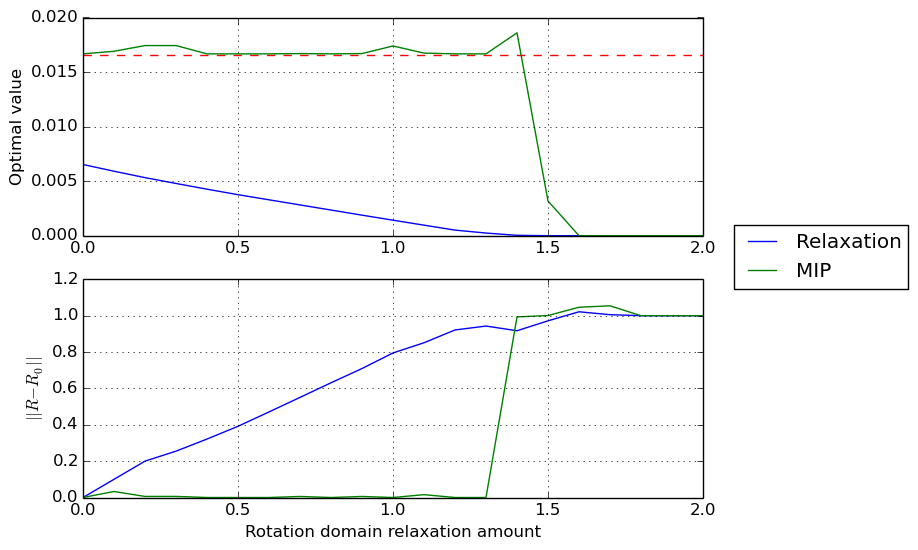

PyObject <matplotlib.text.Text object at 0x7fdca7b0c390>

In [188]:
using PyPlot: plot, scatter, grid, axhline
subplot(2, 1, 1)
axhline(y = 0.0166, linestyle="--", color="r")
grid("on")
for (i, data) in enumerate(datas)
    plot(data.relaxation_amts, data.continuous_relaxation_optimal_vals, label="Relaxation " * names[i])
    plot(data.relaxation_amts, data.integer_feasible_optimal_vals, label="MIP " * names[i])
end
ylabel("Optimal value")
subplot(2, 1, 2)
grid("on")
#axhline(y = 12)
for (i, data) in enumerate(datas)
    plot(data.relaxation_amts, [norm(Rx - R0) for Rx in data.continuous_relaxation_optimal_Rs] , label="Relaxation")
    plot(data.relaxation_amts, [norm(Rx - R0) for Rx in data.integer_feasible_optimal_Rs], label="MIP")
end
legend(bbox_to_anchor=[1.05,1.25],loc=2,borderaxespad=0)
ylabel(L"$||R - R_0||$")
xlabel("Rotation domain relaxation amount")

In [44]:
using PyPlot: plot, scatter, grid, axhline
subplot(2, 1, 1)
axhline(y=0.02, xmin=0, xmax=1, ls="--", color="r")
plot(relaxation_amts, relaxation_vals, label="Relaxed")
plot(relaxation_amts, optimal_vals, label="Complete")
grid("on")
ylim(-0.001, 0.03)
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0)
ylabel("Optimal value")
subplot(2, 1, 2)
plot(relaxation_amts, [norm(Rx - R0) for Rx in relaxation_Rs], label="Relaxed")
plot(relaxation_amts, [norm(Rx - R0) for Rx in optimal_Rs], label="Complete")
ylabel(L"$||R - R_0||$")
grid("on")
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0)
xlabel(L"Relaxation amount (max row- and column-wise L1 norm of $R - R_0$)")

LoadError: UndefVarError: relaxation_amts not defined

In [120]:
type PartialSpecificationData 
    n_scene::Int
    n_outliers::Int
    num_corresponds_specified::Array{Float64}
    optimal_vals_relax::Array{Float64}
    optimal_vals_mip::Array{Float64}
    R_l2_error_relax::Array{Float64}
    R_l2_error_mip::Array{Float64}
    relaxation_amts::Array{Float64}
end

In [152]:
function do_specifications(model_data, to_specify, assign_correctly)
    for i in 1:to_specify
        if (!assign_correctly)
            # Negative assignments
            k_random_assignment = rand(1:size(scenePointsFacesGT, 2))
            while (scenePointsFacesGT[i, k_random_assignment] == 1)
                k_random_assignment = rand(1:size(scenePointsFacesGT, 2))
            end
            @constraint(model_data.m, model_data.f[i, k_random_assignment] == 1)
        else
            for k in 1:size(scenePointsFacesGT, 2)

                # positive assignment
                if (scenePointsFacesGT[i, k] == 1)
                    @constraint(model_data.m, model_data.f[i, k] == 1)
                end
            end
        end
    end
end
run_data = PartialSpecificationData(size(scenePoints, 2), N_outliers, [], [], [], [], [], [])
for to_specify in 0:1:size(scenePoints, 2)
    # Exact
    model_data = constructModel(false, 10.0, R0)
    addinfocallback(model_data.m, infocallback, when = :Intermediate)
    do_specifications(model_data, to_specify, false)
    #status = solve(model_data.m)
    push!(run_data.num_corresponds_specified, to_specify)
    #push!(run_data.optimal_vals_mip, getobjectivevalue(model_data.m))
    #push!(run_data.R_l2_error_mip, norm(getvalue(model_data.R) - R0))
    
    # Relaxed
    model_data = constructModel(true, 10.0, R0)
    addinfocallback(model_data.m, infocallback, when = :Intermediate)
    do_specifications(model_data, to_specify, false)
    status = solve(model_data.m)
    push!(run_data.optimal_vals_relax, getobjectivevalue(model_data.m))
    push!(run_data.R_l2_error_relax, norm(getvalue(model_data.R) - R0))
    
    println("Iter ", to_specify, " optimal cost ", getobjectivevalue(model_data.m))
end

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 3448 rows, 5030 columns and 26108 nonzeros
Coefficient statistics:
  Matrix range     [2e-03, 1e+01]
  Objective range  [5e-04, 5e-03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 1e+01]
Presolve removed 200 rows and 200 columns
Presolve time: 0.01s
Presolved: 3248 rows, 4830 columns, 25308 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.110811e+02   0.000000e+00      0s
    1175    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1175 iterations and 0.12 seconds
Optimal objective  0.000000000e+00
Iter 0 optimal cost 0.0


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 3449 rows, 5030 columns and 26109 nonzeros
Coefficient statistics:
  Matrix range     [2e-03, 1e+01]
  Objective range  [5e-04, 5e-03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 1e+01]
Presolve removed 210 rows and 218 columns
Presolve time: 0.01s
Presolved: 3239 rows, 4812 columns, 25227 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.447815e+02   0.000000e+00      0s
    1727    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1727 iterations and 0.19 seconds
Optimal objective  0.000000000e+00
Iter 1 optimal cost 0.0
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 3450 rows, 5030 columns and 26110 nonzeros
Coefficient statistics:
  Matrix range     [2e-03, 1e+01]
  Objective range  [5e-04, 5e-03]
  Bounds range     [1e+00, 1e+01]
  RHS range       

In [156]:
partial_corresp_data_200s_100o_neg = deepcopy(run_data);

In [157]:
using JLD
save("partial_corresp_data_200s_100o_neg.jld", "partial_corresp_data_200s_100o_neg", partial_corresp_data_200s_100o_neg)

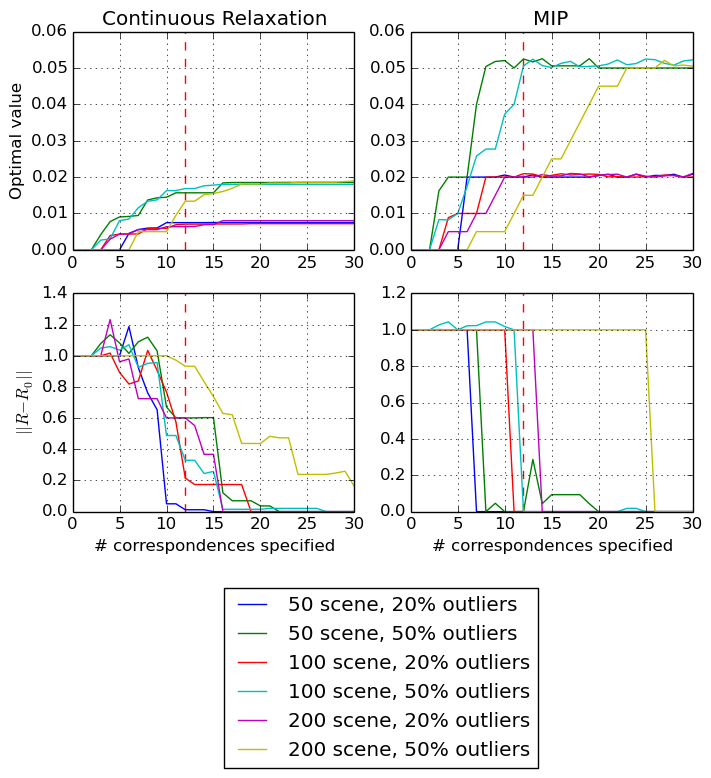

PyObject <matplotlib.legend.Legend object at 0x7fdcae404f90>

In [135]:
partial_corresp_data_50s_25o = load("partial_corresp_data_50s_25o.jld")["partial_corresp_data_50s_25o"];
partial_corresp_data_50s_10o = load("partial_corresp_data_50s_10o.jld")["partial_corresp_data_50s_10o"];
partial_corresp_data_100s_20o = load("partial_corresp_data_100s_20o.jld")["partial_corresp_data_100s_20o"];
partial_corresp_data_100s_50o = load("partial_corresp_data_100s_50o.jld")["partial_corresp_data_100s_50o"];
partial_corresp_data_200s_40o = load("partial_corresp_data_200s_40o.jld")["partial_corresp_data_200s_40o"];
partial_corresp_data_200s_100o = load("partial_corresp_data_200s_100o.jld")["partial_corresp_data_200s_100o"];
datas = [partial_corresp_data_50s_10o, partial_corresp_data_50s_25o, 
         partial_corresp_data_100s_20o, partial_corresp_data_100s_50o, 
    partial_corresp_data_200s_40o, partial_corresp_data_200s_100o]
names = ["50 scene, 20% outliers", "50 scene, 50% outliers", "100 scene, 20% outliers", 
    "100 scene, 50% outliers", "200 scene, 20% outliers", "200 scene, 50% outliers"];

using PyPlot: plot, scatter, grid, axhline
subplot(2, 2, 1)
title("Continuous Relaxation")
ylabel("Optimal value")
ylim(0, 0.06)
xlim(0, 30)
grid("on")
axvline(x = 12, linestyle="--", color="r")
for (i, data) in enumerate(datas)
    plot(data.num_corresponds_specified, data.optimal_vals_relax, label=names[i])
end
subplot(2, 2, 2)
title("MIP")
grid("on")
ylim(0, 0.06)
xlim(0, 30)
axvline(x = 12, linestyle="--", color="r")
for (i, data) in enumerate(datas)
    plot(data.num_corresponds_specified, data.optimal_vals_mip, label=names[i])
end
subplot(2, 2, 3)
ylabel(L"||R - R_0||")
xlim(0, 30)
grid("on")
axvline(x = 12, linestyle="--", color="r")
xlabel("# correspondences specified")
for (i, data) in enumerate(datas)
    plot(data.num_corresponds_specified, data.R_l2_error_relax, label=names[i])
end
subplot(2, 2, 4)
grid("on")
xlim(0, 30)
xlabel("# correspondences specified")
axvline(x = 12, linestyle="--", color="r")
for (i, data) in enumerate(datas)
    plot(data.num_corresponds_specified, data.R_l2_error_mip, label=names[i])
end
legend(bbox_to_anchor=[0.45,-0.35],loc=1,borderaxespad=0)

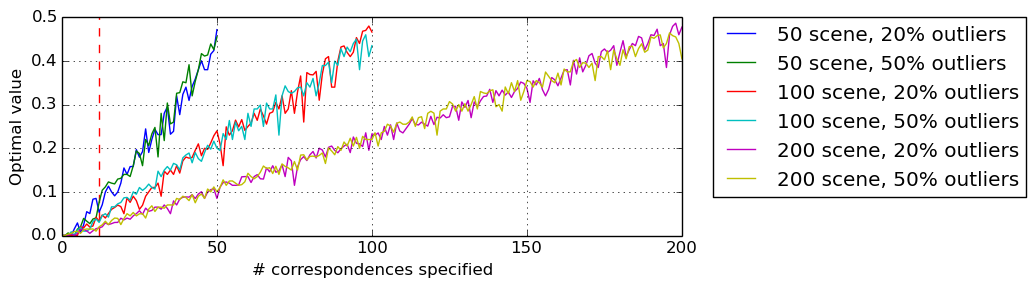

PyObject <matplotlib.legend.Legend object at 0x7fdcac5b51d0>

In [179]:
partial_corresp_data_50s_25o_neg = load("partial_corresp_data_50s_25o_neg.jld")["partial_corresp_data_50s_25o_neg"];
partial_corresp_data_50s_10o_neg = load("partial_corresp_data_50s_10o_neg.jld")["partial_corresp_data_50s_10o_neg"];
partial_corresp_data_100s_20o_neg = load("partial_corresp_data_100s_20o_neg.jld")["partial_corresp_data_100s_20o_neg"];
partial_corresp_data_100s_50o_neg = load("partial_corresp_data_100s_50o_neg.jld")["partial_corresp_data_100s_50o_neg"];
partial_corresp_data_200s_40o_neg = load("partial_corresp_data_200s_40o_neg.jld")["partial_corresp_data_200s_40o_neg"];
partial_corresp_data_200s_100o_neg = load("partial_corresp_data_200s_100o_neg.jld")["partial_corresp_data_200s_100o_neg"];
datas = [partial_corresp_data_50s_10o_neg, partial_corresp_data_50s_25o_neg, 
    partial_corresp_data_100s_20o_neg, partial_corresp_data_100s_50o_neg,
    partial_corresp_data_200s_40o_neg, partial_corresp_data_200s_100o_neg]
names = ["50 scene, 20% outliers", "50 scene, 50% outliers", "100 scene, 20% outliers", "100 scene, 50% outliers",
    "200 scene, 20% outliers", "200 scene, 50% outliers"];

using PyPlot: plot, scatter, grid, axhline
subplot(2, 1, 1)
ylabel("Optimal value")
#ylim(0, 0.06)
grid("on")
axvline(x = 12, linestyle="--", color="r")
for (i, data) in enumerate(datas)
    plot(data.num_corresponds_specified, data.optimal_vals_relax, label=names[i])
end
xlabel("# correspondences specified")

#subplot(2, 1, 2)
#ylabel(L"||R - R_0||")
#ylim(0, 3.0)
#grid("on")
#axvline(x = 12, linestyle="--", color="r")
#xlabel("# correspondences specified")
#for (i, data) in enumerate(datas)
#    plot(data.num_corresponds_specified, data.R_l2_error_relax, label=names[i])
#end
legend(bbox_to_anchor=[1.05, 1.0], loc=2, borderaxespad=0)
#legend(bbox_to_anchor=[0.75,-0.35],loc=1,borderaxespad=0)

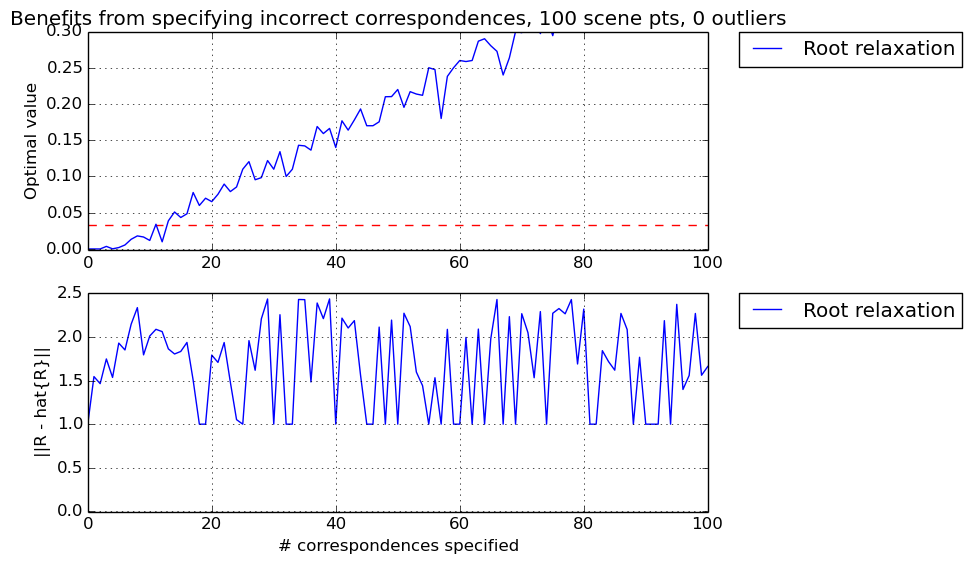

PyObject <matplotlib.legend.Legend object at 0x7f2d046e7750>

In [25]:
optimal_vals_mip = num_corresponds_specified
R_l2_error_mip = num_corresponds_specified

subplot(2, 1, 1)
title("Benefits from specifying incorrect correspondences, $(size(modelPoints, 2)) scene pts, $(N_outliers) outliers")
axhline(y=0.0333, xmin=0, xmax=1, ls="--", color="r")
plot(num_corresponds_specified, optimal_vals_relax, label="Root relaxation")
#plot(num_corresponds_specified, optimal_vals_mip, label="MIP")
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0)
ylabel("Optimal value")
grid("on")
ylim(-0.001, 0.3)
subplot(2, 1, 2)
plot(num_corresponds_specified, R_l2_error_relax, label="Root relaxation")
#plot(num_corresponds_specified, R_l2_error_mip, label="MIP")
ylabel("||R - hat{R}||")
grid("on")
ylim(-0.001, 2.5)
xlabel("# correspondences specified")
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0)

(101,)
(101,)
(101,)
